In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

2024-07-18 02:16:20.542296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 02:16:21.199952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)



In [3]:
# # Check for GPU availability
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
#     except RuntimeError as e:
#         print(e)
# else:
#     print("No GPUs found. Using CPU.")

In [4]:
# Set up logging and checkpoint directories
checkpoint_path = "training_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:

# Preprocessing function
def preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (100, 100))
    image = image / 255.0
    return image


In [6]:
# Function to preprocess a triplet of images
def preprocess_triplet(anchor_path, positive_path, negative_path):
    return (
        preprocess(anchor_path),
        preprocess(positive_path),
        preprocess(negative_path)
    )


In [7]:
# Define paths to your data directories
ANC_PATH = 'build_siamies_network/data/anchor'
POS_PATH = 'build_siamies_network/data/positive'
NEG_PATH = 'build_siamies_network/data/negative'

In [8]:
# Load image paths
anchor_paths = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg'), shuffle=False)
positive_paths = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg'), shuffle=False)
negative_paths = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg'), shuffle=False)


2024-07-18 02:16:22.101660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 02:16:22.131863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 02:16:22.132209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
triplets = tf.data.Dataset.zip((anchor_paths, positive_paths, negative_paths))

In [10]:
# Map preprocessing function to the dataset
data = triplets.map(lambda anchor, positive, negative: preprocess_triplet(anchor, positive, negative))
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [11]:
# Split into training and testing datasets
dataset_size = len(list(data))
train_size = int(0.7 * dataset_size)
train_data = data.take(train_size)
test_data = data.skip(train_size)

2024-07-18 02:16:22.391016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [313]
	 [[{{node Placeholder/_0}}]]
2024-07-18 02:16:22.391262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [13233]
	 [[{{node Placeholder/_4}}]]


In [12]:
# Add dummy targets
def add_dummy_target(anchor, positive, negative):
    return (anchor, positive, negative), tf.zeros((1,))

In [13]:
# Batch and prefetch datasets
batch_size = 2
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).map(add_dummy_target)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).map(add_dummy_target)


In [14]:
# Embedding model architecture
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    x = Conv2D(64, (10, 10), activation='relu')(inp)
    x = MaxPooling2D(2, 2, padding='same')(x)
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(2, 2, padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(2, 2, padding='same')(x)
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=x, name='embedding')

In [15]:
# Triplet loss function
def triplet_loss(margin=0.5):
    def _triplet_loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        basic_loss = pos_dist - neg_dist + margin
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))
        return loss
    return _triplet_loss


In [16]:
# Triplet model architecture
def make_triplet_model(embedding_model):
    anchor_input = Input(shape=(100, 100, 3), name='anchor')
    positive_input = Input(shape=(100, 100, 3), name='positive')
    negative_input = Input(shape=(100, 100, 3), name='negative')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
    
    merged_vector = tf.stack([anchor_embedding, positive_embedding, negative_embedding], axis=1)
    
    triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
    triplet_model.compile(loss=triplet_loss(margin=0.5), optimizer='adam')
    return triplet_model

In [17]:
# Create and compile the embedding model
embedding_model = make_embedding()
embedding_model.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [18]:
# Create and compile the triplet model
triplet_model = make_triplet_model(embedding_model)
triplet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                            

In [19]:
# Create checkpoints and TensorBoard callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq='epoch')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [20]:
# Train the triplet model
epochs = 20
history = triplet_model.fit(
    train_data, 
    validation_data=test_data, 
    epochs=epochs, 
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/20


2024-07-18 02:16:23.063207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [313]
	 [[{{node Placeholder/_0}}]]
2024-07-18 02:16:23.063459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [13233]
	 [[{{node Placeholder/_4}}]]
2024-07-18 02:16:23.954760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-07-18 02:16:24.275764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-18 

106/107 [============================>.] - ETA: 0s - loss: 1.9301

2024-07-18 02:16:27.863530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [307]
	 [[{{node Placeholder/_2}}]]
2024-07-18 02:16:27.863991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [307]
	 [[{{node Placeholder/_2}}]]
2024-07-18 02:16:28.381235: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 283.59MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-1


Epoch 1: saving model to training_checkpoints/cp-0001.ckpt


2024-07-18 02:16:29.976484: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


107/107 [==============================] - 13s 96ms/step - loss: 1.9168 - val_loss: 0.5684
Epoch 2/20
106/107 [============================>.] - ETA: 0s - loss: 0.4824
Epoch 2: saving model to training_checkpoints/cp-0002.ckpt


2024-07-18 02:16:40.701172: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


107/107 [==============================] - 7s 67ms/step - loss: 0.4826 - val_loss: 0.5000
Epoch 3/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 3: saving model to training_checkpoints/cp-0003.ckpt


2024-07-18 02:16:46.921070: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


107/107 [==============================] - 6s 59ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 4: saving model to training_checkpoints/cp-0004.ckpt


2024-07-18 02:16:53.293655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


107/107 [==============================] - 6s 57ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 5/20
105/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 5: saving model to training_checkpoints/cp-0005.ckpt


2024-07-18 02:16:59.605584: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9059696640 exceeds 10% of free system memory.


107/107 [==============================] - 6s 57ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 6/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 6: saving model to training_checkpoints/cp-0006.ckpt
107/107 [==============================] - 6s 58ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 7/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 7: saving model to training_checkpoints/cp-0007.ckpt
107/107 [==============================] - 6s 56ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 8/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 8: saving model to training_checkpoints/cp-0008.ckpt
107/107 [==============================] - 7s 65ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 9/20
106/107 [============================>.] - ETA: 0s - loss: 0.5000
Epoch 9: saving model to training_checkpoints/cp-0009.ckpt
107/107 [==============================] - 6s 58ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 

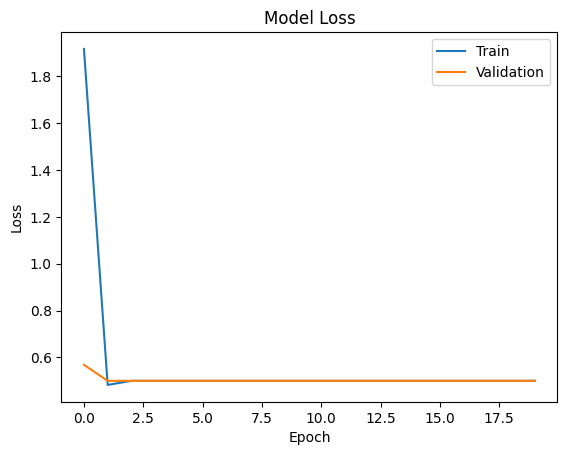

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [27]:
triplet_model.save('triplet_model.h5')

In [28]:
from tensorflow.keras.metrics import Precision, Recall